# Univariate n-lagged Random Forest  

From:  https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Random Forest models leverage the value of many trained decision trees - making it an ensemble technique - to come up with an estimator that delivers the best balance between goodness of fit (low bias) and generalization (low variance).  In regression modelling this means averaging the output of the estimates, while in classification this means a "win by votes".  

Timeseries data can be processed to be modelled using supervised learning algotithms like Random Forest.  The data must be "lagged", that is, the model is prompted to predict a target at time t using information from time t-1 (or t-n if n lags are imposed).  And this can be done for an autoregression, where a target is predicted based only on past values of itself, or it can be done for a multivariate scenario where a target variable is predicted on past values of itself and past values for the feature variables that impact on the target.

Here is an overview of the steps carried out in this effort:
* The raw dataset must be lagged to the desired lag value, and the lagged versions of the variables must be collated for input  
> For this univariate model, it was found in the EDA that a lag of one would likely do best.  However the code below does allow for setting a different lag value.
* The variables are split into training and test datasets
* The RandomForest is configured and fit on training data
* Predicted values are generated as "one-step" walking forecast predictions on a model re-fit with the training dataset and the last-used test data point/row.  
* These one-step walking forecast predictions are compared to their actual observations for plotting and the calculation of mean absolute error (MAE).  This mirrors a set-up where models are updated real-time on observed data as it is available.
* Predictions are also produced for a "static model" that is fit only once on the training data, and the test data is input in one step to obtain the predictions.  Plots of the predicted and expected values are produced and the MAE is calculated.

## Stationarity   

In the eda notebooks, the data was found to be stationary by the Augmented Dickey-Fuller test.

To check for stationarity in Python, consult the following:  
https://machinelearningmastery.com/time-series-data-stationary-python/  

Tests for stationarity, generally:  

"There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data."  (Analytics Vidhya)  

## Predicting on a Real-Time Fitted Model  

One can imagine two scenarios, generally:  

1.  One where a model is fit on a large and rich set of data, the fit model is used for any new observations that come in, and a model refresh occurs after some set of conditions have been met (time, significant change in process, model performance degradation, etc).

2.  Another where a model is fit also on a fairly large and rich set of data, it generates predictions, but as new observations are recorded, the model is re-fit with the prior history and the new observations, which then generates predictions on a presumably more up-to-date model.

The below presents the second scenario and its results, and below this is the first scenario, "static model" predictions.  Comments on the pitfalls of real-time model refitting are found in the second section.

#### What is the Walk-Forward Validation doing?  

To be clear:  the model is fit to training data for "round 1".  A row from the test set is sent for prediction - no re-training using that or any other test row - and the prediction is stored alongside its corresponding actual test value for error calculation.

Next, that test row is stored to a variable, history, which was already populated with the training set.  Round 2 sends the next row of the test set, but first, the model is re-fit to the history which now contains the original training data set plus the previous row of test data.  As the modelling error was already calculated on that row, we're now considering it as "seen data" and using it to refit the model.  This freshly re-fit model is then used to predict the target on the 2nd (latest) test set row, and the error calculation is done on that result.  

Again, that latest test row is added to the history variable, now growing longer as it gains rows of "seen" test data appended to the training data.  The sequence is taken up again.

## Models  


### Preliminary Settings to Import Modules and Data  

In [1]:
import sys
import os
print("Before anything is modified here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())
os.chdir('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue')
sys.path.append('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src')
print("\nNow that things have been modified, here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())

Before anything is modified here are the system path and the current working directory:
['c:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\notebooks', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\python310.zip', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\DLLs', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds', '', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\Pythonwin']
c:\Users\ron_d\lhl_capstone\multivariate_timeseries_forecasting_dengue\notebooks

Now that things have been modified, here are the system path and the current working directory:
['c:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\notebooks', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\python310.

In [2]:
import numpy as np
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from timeseries_data_prep import series_to_supervised_uv, train_test_split_rows_reserved
from one_step_forecasts import random_forest_forecast, walk_fwd_validation_rf

### Data Import and Preparation  

In [3]:
# Get the absolute path to the project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adjust the path to your data file
data_file_path = os.path.join(project_dir, 'multivariate_timeseries_forecasting_dengue', 'data', 'sj_df.csv')

# Read the CSV using the relative path
sj_df = pd.read_csv(data_file_path, header=0, index_col=0)

# Select the total_cases data
sj_df_cases = sj_df['total_cases']

# Send the values to a list
sj_df_cases_list = sj_df_cases.values.astype('float32').tolist()

# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Optional check
print(f"Raw total_cases: {sj_df_cases_list}")

# transform the time series data into supervised learning
data = series_to_supervised_uv(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up

# a red flag is if you're doing a univariate timeseries with lag 1 and you're getting more than 2 columns when this prints
print(f"With lagged input as first column: \n{data}")

Raw total_cases: [4.0, 5.0, 4.0, 3.0, 6.0, 2.0, 4.0, 5.0, 10.0, 6.0, 8.0, 2.0, 6.0, 17.0, 23.0, 13.0, 21.0, 28.0, 24.0, 20.0, 40.0, 27.0, 42.0, 33.0, 43.0, 37.0, 57.0, 71.0, 44.0, 56.0, 53.0, 52.0, 47.0, 26.0, 27.0, 21.0, 21.0, 26.0, 34.0, 37.0, 17.0, 19.0, 25.0, 18.0, 21.0, 17.0, 17.0, 16.0, 16.0, 15.0, 23.0, 16.0, 17.0, 12.0, 17.0, 10.0, 15.0, 19.0, 21.0, 14.0, 18.0, 13.0, 14.0, 18.0, 23.0, 25.0, 62.0, 60.0, 76.0, 66.0, 64.0, 68.0, 89.0, 92.0, 140.0, 116.0, 142.0, 129.0, 140.0, 140.0, 127.0, 129.0, 169.0, 141.0, 108.0, 78.0, 70.0, 81.0, 104.0, 90.0, 85.0, 55.0, 53.0, 65.0, 33.0, 38.0, 59.0, 40.0, 37.0, 29.0, 30.0, 30.0, 28.0, 23.0, 24.0, 29.0, 26.0, 23.0, 20.0, 19.0, 20.0, 26.0, 29.0, 31.0, 28.0, 26.0, 32.0, 35.0, 33.0, 30.0, 52.0, 59.0, 67.0, 65.0, 74.0, 70.0, 61.0, 53.0, 76.0, 61.0, 57.0, 44.0, 34.0, 47.0, 60.0, 60.0, 53.0, 36.0, 31.0, 30.0, 32.0, 28.0, 33.0, 33.0, 35.0, 22.0, 13.0, 13.0, 21.0, 17.0, 11.0, 8.0, 8.0, 6.0, 6.0, 7.0, 12.0, 17.0, 10.0, 10.0, 18.0, 19.0, 12.0, 22.0, 12.

## Baseline Random Forest Univariate Model  

Starting with a 12 row test set to gauge performance and run time.

>expected=2.0, predicted=9.3
>expected=6.0, predicted=4.2
>expected=8.0, predicted=6.4
>expected=5.0, predicted=9.8
>expected=1.0, predicted=6.3
>expected=2.0, predicted=3.7
>expected=3.0, predicted=4.3
>expected=4.0, predicted=4.8
>expected=3.0, predicted=6.1
>expected=1.0, predicted=4.8
>expected=3.0, predicted=3.5
>expected=5.0, predicted=4.7
MAE: 2.689


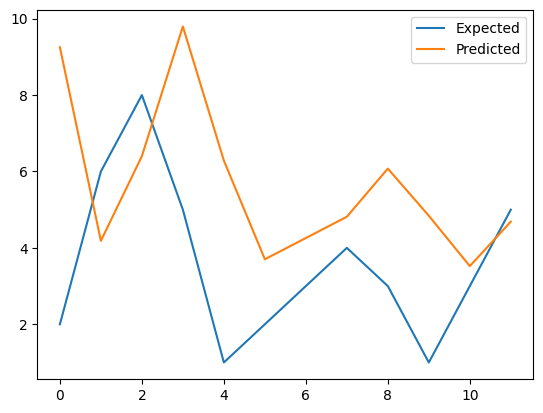

In [4]:
# evaluate
mae, y, yhat = walk_fwd_validation_rf(data, 12)
print('MAE: %.3f' % mae)

pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Trying with a different test set size to see impact on MAE  

Test set size going from 12 to 20.  There's a slight increase in MAE.

>expected=12.0, predicted=17.2
>expected=13.0, predicted=14.9
>expected=17.0, predicted=14.5
>expected=15.0, predicted=17.0
>expected=14.0, predicted=17.3
>expected=15.0, predicted=13.1
>expected=10.0, predicted=17.0
>expected=9.0, predicted=12.7
>expected=2.0, predicted=9.3
>expected=6.0, predicted=4.2
>expected=8.0, predicted=6.4
>expected=5.0, predicted=9.7
>expected=1.0, predicted=6.3
>expected=2.0, predicted=3.7
>expected=3.0, predicted=4.3
>expected=4.0, predicted=4.9
>expected=3.0, predicted=6.2
>expected=1.0, predicted=4.8
>expected=3.0, predicted=3.5
>expected=5.0, predicted=4.7
MAE: 2.997


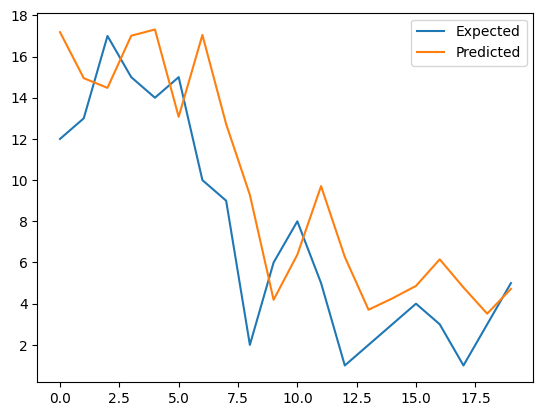

In [6]:
# evaluate
mae, y, yhat = walk_fwd_validation_rf(data, 20)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Trying with a different test set size to see impact on MAE  

Test set size going from 20 to 50.  There's a sharper increase in MAE.

>expected=13.0, predicted=9.6
>expected=10.0, predicted=14.7
>expected=21.0, predicted=12.5
>expected=18.0, predicted=21.9
>expected=21.0, predicted=16.4
>expected=34.0, predicted=21.6
>expected=25.0, predicted=32.7
>expected=34.0, predicted=28.2
>expected=33.0, predicted=32.0
>expected=40.0, predicted=32.2
>expected=42.0, predicted=32.1
>expected=36.0, predicted=35.7
>expected=72.0, predicted=35.8
>expected=75.0, predicted=63.8
>expected=76.0, predicted=66.1
>expected=92.0, predicted=64.0
>expected=71.0, predicted=115.1
>expected=112.0, predicted=73.9
>expected=106.0, predicted=105.0
>expected=101.0, predicted=92.2
>expected=170.0, predicted=119.3
>expected=135.0, predicted=149.9
>expected=106.0, predicted=126.4
>expected=68.0, predicted=97.5
>expected=48.0, predicted=65.8
>expected=48.0, predicted=47.2
>expected=26.0, predicted=47.4
>expected=33.0, predicted=27.1
>expected=29.0, predicted=32.7
>expected=17.0, predicted=27.5
>expected=12.0, predicted=17.1
>expected=13.0, predicted=14.

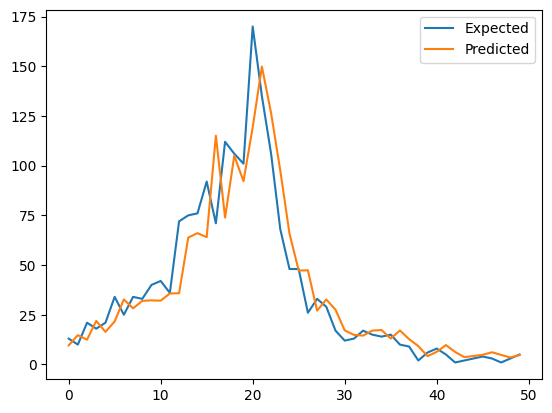

In [7]:
# evaluate
mae, y, yhat = walk_fwd_validation_rf(data, 50)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Trying with a different test set size to see impact on MAE  

Test set size going from 50 to 100.  

Let's agree that I should probably walk this up to the size of test sets used in the other modelling algorithms.  Interesting:  the MAE dropped a bit wrt the test set of 50.  Hmmmm.

>expected=11.0, predicted=6.1
>expected=5.0, predicted=11.6
>expected=5.0, predicted=6.3
>expected=6.0, predicted=6.3
>expected=6.0, predicted=6.4
>expected=4.0, predicted=6.5
>expected=4.0, predicted=6.4
>expected=8.0, predicted=6.2
>expected=14.0, predicted=9.1
>expected=12.0, predicted=12.8
>expected=16.0, predicted=14.1
>expected=10.0, predicted=15.9
>expected=16.0, predicted=12.7
>expected=18.0, predicted=15.6
>expected=15.0, predicted=16.6
>expected=23.0, predicted=17.1
>expected=17.0, predicted=18.2
>expected=33.0, predicted=16.5
>expected=15.0, predicted=33.6
>expected=13.0, predicted=17.4
>expected=11.0, predicted=15.6
>expected=14.0, predicted=11.2
>expected=17.0, predicted=12.8
>expected=19.0, predicted=17.0
>expected=20.0, predicted=19.7
>expected=12.0, predicted=18.0
>expected=21.0, predicted=14.2
>expected=7.0, predicted=23.5
>expected=19.0, predicted=8.7
>expected=10.0, predicted=19.9
>expected=13.0, predicted=12.8
>expected=10.0, predicted=15.4
>expected=8.0, predicted=

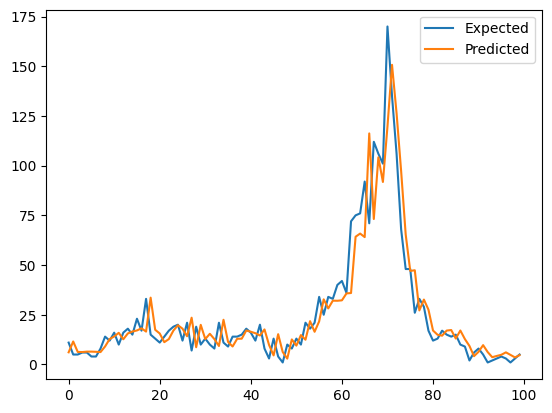

In [8]:
# evaluate
mae, y, yhat = walk_fwd_validation_rf(data, 100)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Trying with a different test set size to see impact on MAE  

Test set size going from 100 to 200.  

I really do need to check what test set size I used on other models... I seem to recall it was ~280 for AutoReg.  I forget for LSTM.  I'll get on it.  

MAE around 7, vs 7.5 at 100 row test set.  Interesting.

>expected=13.0, predicted=15.7
>expected=8.0, predicted=15.5
>expected=21.0, predicted=8.2
>expected=18.0, predicted=23.3
>expected=8.0, predicted=17.1
>expected=7.0, predicted=9.1
>expected=20.0, predicted=9.0
>expected=14.0, predicted=18.2
>expected=14.0, predicted=13.2
>expected=7.0, predicted=13.2
>expected=14.0, predicted=9.4
>expected=10.0, predicted=12.9
>expected=13.0, predicted=12.4
>expected=27.0, predicted=15.0
>expected=13.0, predicted=26.8
>expected=18.0, predicted=15.8
>expected=16.0, predicted=16.6
>expected=16.0, predicted=15.7
>expected=20.0, predicted=15.7
>expected=17.0, predicted=18.1
>expected=4.0, predicted=17.7
>expected=15.0, predicted=5.7
>expected=8.0, predicted=18.6
>expected=6.0, predicted=9.0
>expected=12.0, predicted=6.4
>expected=15.0, predicted=14.5
>expected=11.0, predicted=17.5
>expected=10.0, predicted=12.1
>expected=15.0, predicted=12.3
>expected=17.0, predicted=17.1
>expected=7.0, predicted=17.2
>expected=7.0, predicted=9.6
>expected=8.0, predicted=

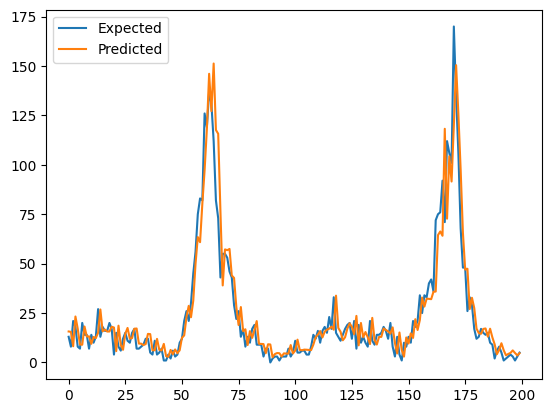

In [9]:
# evaluate
mae, y, yhat = walk_fwd_validation_rf(data, 200)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Trying with a different test set size to see impact on MAE  

One last round for fun.  Test set size going from 200 to 300.  

MAE dropped to 6!  Ok, now let's try increasing the test size on the static model.  I'll do it in fewer steps.

>expected=3.0, predicted=4.7
>expected=5.0, predicted=4.5
>expected=4.0, predicted=6.2
>expected=7.0, predicted=5.9
>expected=6.0, predicted=9.8
>expected=5.0, predicted=5.9
>expected=7.0, predicted=6.0
>expected=6.0, predicted=9.5
>expected=4.0, predicted=5.9
>expected=4.0, predicted=5.9
>expected=7.0, predicted=5.8
>expected=9.0, predicted=9.2
>expected=5.0, predicted=10.3
>expected=5.0, predicted=6.1
>expected=10.0, predicted=6.0
>expected=6.0, predicted=12.7
>expected=13.0, predicted=5.8
>expected=6.0, predicted=17.1
>expected=5.0, predicted=6.1
>expected=5.0, predicted=6.3
>expected=9.0, predicted=6.3
>expected=3.0, predicted=9.9
>expected=6.0, predicted=4.5
>expected=11.0, predicted=6.1
>expected=7.0, predicted=13.0
>expected=7.0, predicted=9.2
>expected=15.0, predicted=9.0
>expected=9.0, predicted=19.4
>expected=6.0, predicted=9.4
>expected=6.0, predicted=6.2
>expected=6.0, predicted=6.2
>expected=7.0, predicted=6.2
>expected=10.0, predicted=9.5
>expected=8.0, predicted=12.1
>ex

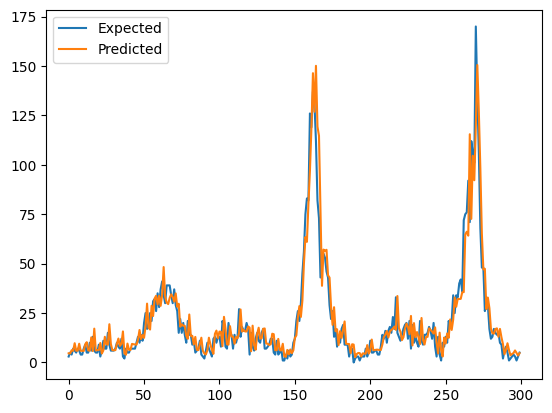

In [10]:
# evaluate
mae, y, yhat = walk_fwd_validation_rf(data, 300)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Predicting on a Static Model  

The below mimics what's done above in the initial set-up where the model is trained on training data (after much processing), but now rather than:
a) feed it one testX row at at time to do a real-time re-fit of the model and generate predictions one step at a time, instead we
b) feed it the entire testX set of rows to get a 'static model' prediction, yhat_static, and get the model error on that  

In many situations, a real-time model re-fit may not be feasible if the computational load is too big, or data cannot be obtained in a timely manner to allow for real-time model updates.  Additionally, real-time model updates come with the additional burden of due diligence:  guardrails must be instituted to ensure 'rogue data' or significant drift in the process being modelled doesn't result in a model that produces significantly erroneous results.  Monitoring error would only be one part of the safeguarding scheme.  There would have to be additional supports like monitoring data quality real-time, among other protections.

Careful not to feed it [test_X], you want to feed it only (test_X) if you're sending it all of testX at a time.

[[  4.   5.]
 [  5.   4.]
 [  4.   3.]
 [  3.   6.]
 [  6.   2.]
 [  2.   4.]
 [  4.   5.]
 [  5.  10.]
 [ 10.   6.]
 [  6.   8.]
 [  8.   2.]
 [  2.   6.]
 [  6.  17.]
 [ 17.  23.]
 [ 23.  13.]
 [ 13.  21.]
 [ 21.  28.]
 [ 28.  24.]
 [ 24.  20.]
 [ 20.  40.]
 [ 40.  27.]
 [ 27.  42.]
 [ 42.  33.]
 [ 33.  43.]
 [ 43.  37.]
 [ 37.  57.]
 [ 57.  71.]
 [ 71.  44.]
 [ 44.  56.]
 [ 56.  53.]
 [ 53.  52.]
 [ 52.  47.]
 [ 47.  26.]
 [ 26.  27.]
 [ 27.  21.]
 [ 21.  21.]
 [ 21.  26.]
 [ 26.  34.]
 [ 34.  37.]
 [ 37.  17.]
 [ 17.  19.]
 [ 19.  25.]
 [ 25.  18.]
 [ 18.  21.]
 [ 21.  17.]
 [ 17.  17.]
 [ 17.  16.]
 [ 16.  16.]
 [ 16.  15.]
 [ 15.  23.]
 [ 23.  16.]
 [ 16.  17.]
 [ 17.  12.]
 [ 12.  17.]
 [ 17.  10.]
 [ 10.  15.]
 [ 15.  19.]
 [ 19.  21.]
 [ 21.  14.]
 [ 14.  18.]
 [ 18.  13.]
 [ 13.  14.]
 [ 14.  18.]
 [ 18.  23.]
 [ 23.  25.]
 [ 25.  62.]
 [ 62.  60.]
 [ 60.  76.]
 [ 76.  66.]
 [ 66.  64.]
 [ 64.  68.]
 [ 68.  89.]
 [ 89.  92.]
 [ 92. 140.]
 [140. 116.]
 [116. 142.]
 [142. 129.]

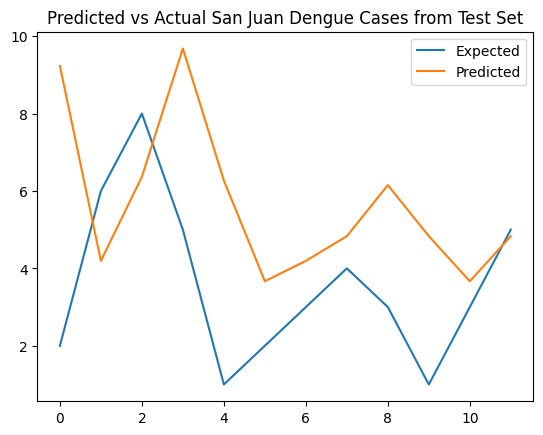

In [13]:
# Pull the data that is output from series_to_supervised
print(data)

# Split the data into a training set and a test set; the training set is used to fit the model
train, test = train_test_split_rows_reserved(data, 12)    

# makes a list of arrays [y(t-1), y(t)]
history = [x for x in train]

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# not certain why we're circling back to the array we had before: train prior to it being fed to [x for x in train].  
# It's still just the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        

# again, history subbed in per parameters fed to random_forest_forecast function; 
# keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last n_test rows of lagged y)
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(testy, yhat_static_test) # not sure why we're not using testy here
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

### Trying a larger test set size for the Dynamic Model  

Going from 12 to 100.  It's fast, it can handle it.  Test MAE 7.3, up from 2.6 on 12 rows of test data.

[[  4.   5.]
 [  5.   4.]
 [  4.   3.]
 [  3.   6.]
 [  6.   2.]
 [  2.   4.]
 [  4.   5.]
 [  5.  10.]
 [ 10.   6.]
 [  6.   8.]
 [  8.   2.]
 [  2.   6.]
 [  6.  17.]
 [ 17.  23.]
 [ 23.  13.]
 [ 13.  21.]
 [ 21.  28.]
 [ 28.  24.]
 [ 24.  20.]
 [ 20.  40.]
 [ 40.  27.]
 [ 27.  42.]
 [ 42.  33.]
 [ 33.  43.]
 [ 43.  37.]
 [ 37.  57.]
 [ 57.  71.]
 [ 71.  44.]
 [ 44.  56.]
 [ 56.  53.]
 [ 53.  52.]
 [ 52.  47.]
 [ 47.  26.]
 [ 26.  27.]
 [ 27.  21.]
 [ 21.  21.]
 [ 21.  26.]
 [ 26.  34.]
 [ 34.  37.]
 [ 37.  17.]
 [ 17.  19.]
 [ 19.  25.]
 [ 25.  18.]
 [ 18.  21.]
 [ 21.  17.]
 [ 17.  17.]
 [ 17.  16.]
 [ 16.  16.]
 [ 16.  15.]
 [ 15.  23.]
 [ 23.  16.]
 [ 16.  17.]
 [ 17.  12.]
 [ 12.  17.]
 [ 17.  10.]
 [ 10.  15.]
 [ 15.  19.]
 [ 19.  21.]
 [ 21.  14.]
 [ 14.  18.]
 [ 18.  13.]
 [ 13.  14.]
 [ 14.  18.]
 [ 18.  23.]
 [ 23.  25.]
 [ 25.  62.]
 [ 62.  60.]
 [ 60.  76.]
 [ 76.  66.]
 [ 66.  64.]
 [ 64.  68.]
 [ 68.  89.]
 [ 89.  92.]
 [ 92. 140.]
 [140. 116.]
 [116. 142.]
 [142. 129.]

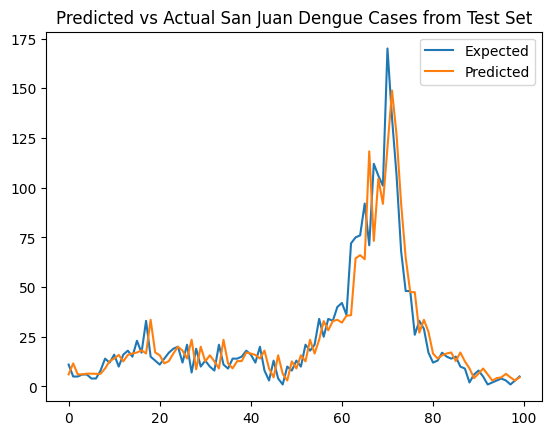

In [14]:
# Pull the data that is output from series_to_supervised
print(data)

# Split the data into a training set and a test set; the training set is used to fit the model
train, test = train_test_split_rows_reserved(data, 100)    

# makes a list of arrays [y(t-1), y(t)]
history = [x for x in train]

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# not certain why we're circling back to the array we had before: train prior to it being fed to [x for x in train].  
# It's still just the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        

# again, history subbed in per parameters fed to random_forest_forecast function; 
# keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last n_test rows of lagged y)
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(testy, yhat_static_test) # not sure why we're not using testy here
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

### Trying a larger test set size for the Dynamic Model  

Going from 100 to 300.  It's fast, it can handle it.  Test MAE down to 6 from 7.3.  

Now let's do this on the multivariate set, but with only the static model.  The dynamic model takes 10 minutes to crunch out 12 rows of test data.  

I may just try *one* trial run at 100 or 200 rows of test data on the dynamic multivariate RF model but on Google Colab.

[[  4.   5.]
 [  5.   4.]
 [  4.   3.]
 [  3.   6.]
 [  6.   2.]
 [  2.   4.]
 [  4.   5.]
 [  5.  10.]
 [ 10.   6.]
 [  6.   8.]
 [  8.   2.]
 [  2.   6.]
 [  6.  17.]
 [ 17.  23.]
 [ 23.  13.]
 [ 13.  21.]
 [ 21.  28.]
 [ 28.  24.]
 [ 24.  20.]
 [ 20.  40.]
 [ 40.  27.]
 [ 27.  42.]
 [ 42.  33.]
 [ 33.  43.]
 [ 43.  37.]
 [ 37.  57.]
 [ 57.  71.]
 [ 71.  44.]
 [ 44.  56.]
 [ 56.  53.]
 [ 53.  52.]
 [ 52.  47.]
 [ 47.  26.]
 [ 26.  27.]
 [ 27.  21.]
 [ 21.  21.]
 [ 21.  26.]
 [ 26.  34.]
 [ 34.  37.]
 [ 37.  17.]
 [ 17.  19.]
 [ 19.  25.]
 [ 25.  18.]
 [ 18.  21.]
 [ 21.  17.]
 [ 17.  17.]
 [ 17.  16.]
 [ 16.  16.]
 [ 16.  15.]
 [ 15.  23.]
 [ 23.  16.]
 [ 16.  17.]
 [ 17.  12.]
 [ 12.  17.]
 [ 17.  10.]
 [ 10.  15.]
 [ 15.  19.]
 [ 19.  21.]
 [ 21.  14.]
 [ 14.  18.]
 [ 18.  13.]
 [ 13.  14.]
 [ 14.  18.]
 [ 18.  23.]
 [ 23.  25.]
 [ 25.  62.]
 [ 62.  60.]
 [ 60.  76.]
 [ 76.  66.]
 [ 66.  64.]
 [ 64.  68.]
 [ 68.  89.]
 [ 89.  92.]
 [ 92. 140.]
 [140. 116.]
 [116. 142.]
 [142. 129.]

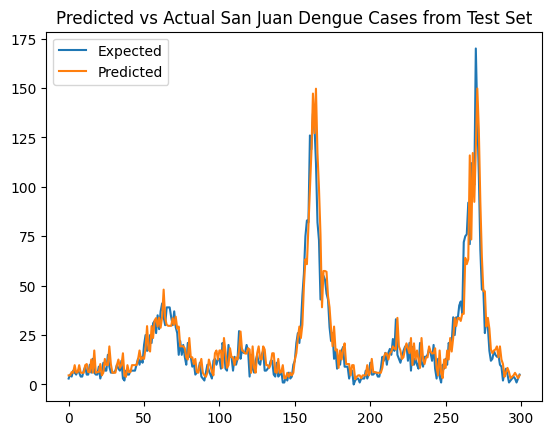

In [15]:
# Pull the data that is output from series_to_supervised
print(data)

# Split the data into a training set and a test set; the training set is used to fit the model
train, test = train_test_split_rows_reserved(data, 300)    

# makes a list of arrays [y(t-1), y(t)]
history = [x for x in train]

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# not certain why we're circling back to the array we had before: train prior to it being fed to [x for x in train].  
# It's still just the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        

# again, history subbed in per parameters fed to random_forest_forecast function; 
# keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last n_test rows of lagged y)
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(testy, yhat_static_test) # not sure why we're not using testy here
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

In [15]:
# # Just to understand what's being sent to `.predict()` (structure)
#testX